# Social Interaction Ethogram Built

Create a panda structure with all relevant parameters for ethogram construction. 

Parameters are based definitions of in de Chaumon et al. Nature 2012. 'Computerized video analysis of social interactions in mice'.

''' May 25th 2021'''


In [3]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
import csv
from collections import namedtuple

In [4]:
def distance(point1,point2):
    xdiff = point1[0] - point2[0]
    ydiff = point1[1] - point2[1]
    dist = np.sqrt(xdiff*xdiff + ydiff*ydiff)
    return dist

def direction(point1,point2):
    x_diff = point1[0] - point2[0]
    y_diff = point1[1] - point2[1]
    direction = np.array([x_diff , y_diff])
    return direction

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [5]:
def get_body_parameters(tracking = None, body_parts = None):
    
    '''
    This function will receive the final positions of body parts (after stimation of nose)
    It will have N*2 entraces, where N is the number of body parts per animal
    For starting point we will use the nose of the tracker and then refine it to another nose position
    using other information (as drive position, maybenose, accelerometer, etc).
    '''
    
    N = int(np.min(tracking.shape)/6)
    tpoints = tracking.shape[0]
    
    #separate animals tracking
    tracking1 = np.array([tracking[:,[i*3,i*3+1]] for i in range(N)])
    tracking2 = np.array([tracking[:,[i*3+N*3,i*3+1+N*3]] for i in range(N)])
    
    print(tracking1.shape)
    
    #compute center of mass taking into account all bodyparts
    cm1 =  np.mean(tracking1,axis=0)
    cm2 =  np.mean(tracking2,axis=0)
    
    #compute speed
    v1 = np.array([np.diff(cm1[:,i], prepend = 0) for i in range(2)]).T
    speed1 = np.linalg.norm(v1,axis = 0)
    v2 = np.array([np.diff(cm2[:,i], prepend = 0) for i in range(2)]).T
    speed2 = np.linalg.norm(v2,axis = 0)
    
    #compute head direction
    hd1= np.array([direction(tracking1[3,i,:],tracking1[0,i,:]) for i in range(tpoints)])
    hd2= np.array([direction(tracking2[3,i,:],tracking1[0,i,:]) for i in range(tpoints)])

    #compute body direction
    bd1= np.array([direction(tracking1[4,i,:],tracking1[3,i,:]) for i in range(tpoints)])
    bd2= np.array([direction(tracking2[4,i,:],tracking1[3,i,:]) for i in range(tpoints)])

    parameters = {'cm1' : cm1 , 'cm2': cm2, 'head_direction1': hd1 , 'head_direction2': hd2 , 
                  'speed1' : speed1, 'speed2': speed2 ,
                  'body_direction1': bd1, 'body_direction2': bd2}

    return parameters

In [140]:
from sklearn.linear_model import LinearRegression

def circle_center(point1,point2,point3):
    
    '''
    Compute the center of the circle along the axis that is perpendicular
    to the ears and intersects nose positions
    input : point1 -> Nose position
            point2 -> RightEar position
            point3 -> LeftEar position
    return : C1 center of circle position
    '''
    
    point4 = (point3 + point2)/2
    C1 = (point1 + point4)/2
    
    return C1

def elipse_focus(point1,point2,point3):
    '''
    Compute the focus of the elipse along the the axis that optimal fits
    neck, com and tail positions.
    input : point1 -> Neck position
            point2 -> Center of mass position
            point3 -> tail position
    return : F1 and F2 focus of the elipsoide
    
    '''
    X = np.array([point1[:,0],point2[:,0],point3[:,0]])
    y = np.array([point1[:,1],point2[:,1],point3[:,1]])
    reg = LinearRegression().fit(X, y)
    
    F1_x = (point1[:,0] + point2[:,0])/2
    F1_y = reg.predict(np.array([F1_x]))
    
    F1 = np.array([F1_x,F1_y])
    
    F2_x = (point2[:,0] + point3[:,0])/2
    F2_y = reg.predict(np.array([F2_x]))
    
    F2 = np.array([F2_x,F2_y])
    return F1,F2


def mouse_model(tracking = None):
    
    point1 = tracking[0,:,:]
    point2 = tracking[1,:,:]
    point3 = tracking[2,:,:]
    head_model = circle_center(point1,point2,point3)
    
    point1 = tracking[3,:,:]
    point2 = tracking[4,:,:]
    point3 = tracking[5,:,:]
    body_model = elipse_focus(point1,point2,point3)
    
    elipse_model = elipse_axis(point1,point2,point3)
    model = namedtuple('mouse_model', ['head', 'body', 'ellipse'])

    return model(head_model , body_model, elipse_model)

In [106]:
tracking_path = Path('/home/melisa/Documents/social_interaction/')
tracking_path.exists()
input_file_name = 'raw120sDLC_resnet50_social_interaction_labelmei19shuffle1_694000.csv'
input_file_path = tracking_path / input_file_name
tracking_DFrame = pd.read_csv(input_file_path)

In [10]:
tracking_DFrame

,scorer,DLC_resnet50_social_interaction_labelmei19shuffle1_694000,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.1,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.2,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.3,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.4,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.5,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.6,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.7,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.8,...,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.41,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.42,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.43,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.44,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.45,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.46,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.47,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.48,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.49,DLC_resnet50_social_interaction_labelmei19shuffle1_694000.50
0,bodyparts,driveFront,driveFront,driveFront,driveRight,driveRight,driveRight,driveBack,driveBack,driveBack,...,visitLear,visitNeck,visitNeck,visitNeck,visitCOM,visitCOM,visitCOM,visitTail,visitTail,visitTail
1,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,...,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
2,0,211.3833465576172,373.9302673339844,0.9999934434890747,203.1659698486328,356.45758056640625,0.9998642206192017,218.48748779296875,351.75396728515625,0.030096322298049927,...,0.00015336275100708008,214.6393280029297,362.8946838378906,1.3917684555053711e-05,227.1283416748047,330.1500244140625,0.00043064355850219727,210.0436248779297,377.4381103515625,0.00019803643226623535
3,1,212.80799865722656,371.64111328125,0.9999926090240479,202.8580780029297,354.2916259765625,0.9998191595077515,218.70013427734375,347.1793212890625,0.02539128065109253,...,0.00014927983283996582,218.6983642578125,364.42962646484375,1.1205673217773438e-05,226.34164428710938,330.44964599609375,0.00030741095542907715,209.29042053222656,377.7365417480469,0.00021249055862426758
4,2,211.00936889648438,370.0245666503906,0.9999783635139465,201.47036743164062,352.418701171875,0.9997755885124207,217.48902893066406,343.8050842285156,0.004842102527618408,...,0.00011658668518066406,218.67543029785156,363.83038330078125,5.0961971282958984e-06,225.55545043945312,330.5709228515625,0.00015297532081604004,234.87672424316406,316.2181091308594,0.0006252527236938477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,3595,271.8031921386719,479.2754211425781,0.9439023733139038,264.00775146484375,497.73248291015625,0.9999886751174927,247.2610626220703,487.8306884765625,0.9999700784683228,...,0.9999679923057556,262.7654113769531,321.2008972167969,0.9999719858169556,226.8140869140625,326.5634765625,0.9999151229858398,185.15411376953125,337.3365173339844,0.9999754428863525
3598,3596,270.6214294433594,480.5617370605469,0.9975413084030151,262.6092529296875,498.45794677734375,0.9999673962593079,245.08619689941406,489.5581359863281,0.9999766945838928,...,0.9999670386314392,263.09539794921875,321.0323486328125,0.9999538660049438,227.21266174316406,326.88427734375,0.9999260902404785,185.2344970703125,337.2430725097656,0.9999765753746033
3599,3597,270.6525573730469,482.14752197265625,0.9991301894187927,262.7396240234375,500.24169921875,0.9999789595603943,245.70729064941406,490.2166748046875,0.9998762607574463,...,0.9999716281890869,264.1067199707031,320.7743225097656,0.999941349029541,228.2958984375,326.7085266113281,0.9999336004257202,185.11436462402344,337.1163635253906,0.9999773502349854
3600,3598,271.26739501953125,483.790283203125,0.9991735219955444,262.052734375,502.0084228515625,0.9999865293502808,245.7251434326172,490.2944641113281,0.999938428401947,...,0.9999595880508423,265.97683715

In [11]:
body_parts = [tracking_DFrame.iloc[0][i*3+1] for i in range(int(len(tracking_DFrame.iloc[0])/3))]
body_part_structure = [tracking_DFrame.iloc[1][i+1] for i in range(3)]

In [12]:
tracking_DFrame = tracking_DFrame.iloc[2:]
tracking_DFrame = tracking_DFrame.astype(float)
tracking_data = tracking_DFrame.to_numpy()

In [13]:
body_tracking = tracking_data[:,1+5*3:]

In [14]:
parameters = get_body_parameters(tracking = body_tracking);
#df = pd.DataFrame(list(parameters.items()),columns = ['cm1','cm2','head_direction1','head_direction2','speed1','speed2','body_direction1','body_directiond2']) 


(6, 3600, 2)


In [15]:
tracking = body_tracking
N = int(np.min(tracking.shape)/6)
#separate animals tracking
tracking1 = np.array([tracking[:,[i*3,i*3+1]] for i in range(N)])
tracking2 = np.array([tracking[:,[i*3+N*3,i*3+1+N*3]] for i in range(N)])
    

In [267]:
def elipse_axis(point1,point2,point3):
    '''
    Compute center and axis lenght of the elipse along the the axis that optimal fits
    neck, com and tail positions.
    input : point1 -> Neck position
            point2 -> Center of mass position
            point3 -> tail position
    return : C center of elipsoide, angle of principal axis and axis1 and axis2 length of the elipsoide
    
    '''
    
    #compute line for principal axis of the elipsoide
    X = np.array([point1[:,0],point2[:,0],point3[:,0]]).T
    y = np.array([point1[:,1],point2[:,1],point3[:,1]]).T
    #print(X.shape)
    #print(y.shape)
    reg = [LinearRegression().fit(X[i,:].reshape(-1,1), y[i].reshape(-1,1)) for i in range(X.shape[0])]
    
    #compute center of the elipsoude
    C_x = (point1[:,0] + point2[:,0] + point3[:,0])/3
    C_y = np.array([float(reg[i].predict(np.array([C_x[i]]).reshape(-1,1))) for i in range(X.shape[0])])
    C = np.array([C_x,C_y]).T
    print(C.shape)
    
    # compute angle of principal axis
    cero = np.zeros_like(C_y)
    bias = np.array([reg[i].predict(cero[i].reshape(-1,1)) for i in range(X.shape[0])])
    print(bias.shape)
    angle =  np.array([float(np.arctan2(C[i,1] - bias[i] , C[i,0])) for i in range(X.shape[0])])
    print(angle.shape)
    
    #compute axis1 and axis2 length 
    axis1 = np.array([np.linalg.norm(point3[i,:]-point1[i,:]) for i in range(X.shape[0])])/2
    axis2 = np.ones_like(axis1)*20
    print(axis1.shape)
    elipse = namedtuple('elipse', ['reg', 'center', 'angle', 'axis1', 'axis2'])
    
    return elipse(reg, C , angle, axis1, axis2)

In [271]:
print(tracking1.shape)
model1 = mouse_model(tracking = tracking1)
model2 = mouse_model(tracking = tracking2)


(6, 3600, 2)
(3600, 2)
(3600, 1, 1)
(3600,)
(3600,)
(3600, 2)
(3600, 1, 1)
(3600,)
(3600,)


In [272]:
#print(model1[2][0][0].coef_)
#print(model1[2][0][0].intercept_)
print(model1[2][1].shape)

(3600, 2)


In [276]:
import cv2
input_video_name = tracking_path / 'raw120s.mp4'
frame_n = 1000

cap = cv2.VideoCapture(str(input_video_name))
#cap.set(cv2.CAP_PROP_POS_FRAMES, frame_n)

output_video = tracking_path / 'ellipse_video.avi'
output = cv2.VideoWriter(str(output_video),cv2.VideoWriter_fourcc(*'MJPG'),30,(700,700))

for frame_n in range(3600):
#     r , frame = cap.read()#cv2.ellipse(frame, tuple(center[0]),(model1.ellipse.axis1[0],model1.ellipse.axis2[0]), model1.ellipse.angle[0], startAngle = 0, endAngle = 360 , color = (0,255,0), thickness = 1)
    
    frame = np.zeros((700,700,3),dtype = 'uint8')
    p1 = (0, model1.ellipse.reg[frame_n].intercept_)
    p2 = (700, 700* model1.ellipse.reg[frame_n].coef_ + model1.ellipse.reg[frame_n].intercept_)
    cv2.line(frame, p1, p2 , color = 255);
    
    p1 = (0, model2.ellipse.reg[frame_n].intercept_)
    p2 = (700, 700* model2.ellipse.reg[frame_n].coef_ + model2.ellipse.reg[frame_n].intercept_)
    cv2.line(frame, p1, p2 , color = (0,0,255));
    #print(model1[2][1][0])

    center1 = model1.ellipse.center
    center2 = model2.ellipse.center
    #print(tuple(center[0]))
    #print((model1.ellipse.axis1[0],model1.ellipse.axis2[0]))
    #print(model1.ellipse.angle[0])

    cv2.circle(frame, tuple(map(int,center1[frame_n])), 10, color = (255,0,0), thickness = 1)
    cv2.ellipse(frame, tuple(map(int,center1[frame_n])),(int(model1.ellipse.axis1[frame_n]),int(model1.ellipse.axis2[frame_n])) , math.degrees(model1.ellipse.angle[frame_n])  , 0, 360, color = (0,0,255), thickness = 5);
    
    cv2.circle(frame, tuple(map(int,center2[frame_n])), 10, color = (255,0,0), thickness = 1)
    cv2.ellipse(frame, tuple(map(int,center2[frame_n])),(int(model2.ellipse.axis1[frame_n]),int(model2.ellipse.axis2[frame_n])) , math.degrees(model2.ellipse.angle[frame_n])  , 0, 360, color = (0,255,0), thickness = 5);
    
    output.write(frame)
    

In [262]:
?cv2.VideoWriter


Init signature: cv2.VideoWriter(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           ~/anaconda3/envs/DLC-CPU/lib/python3.7/site-packages/cv2/cv2.cpython-37m-x86_64-linux-gnu.so
Type:           type
Subclasses:     


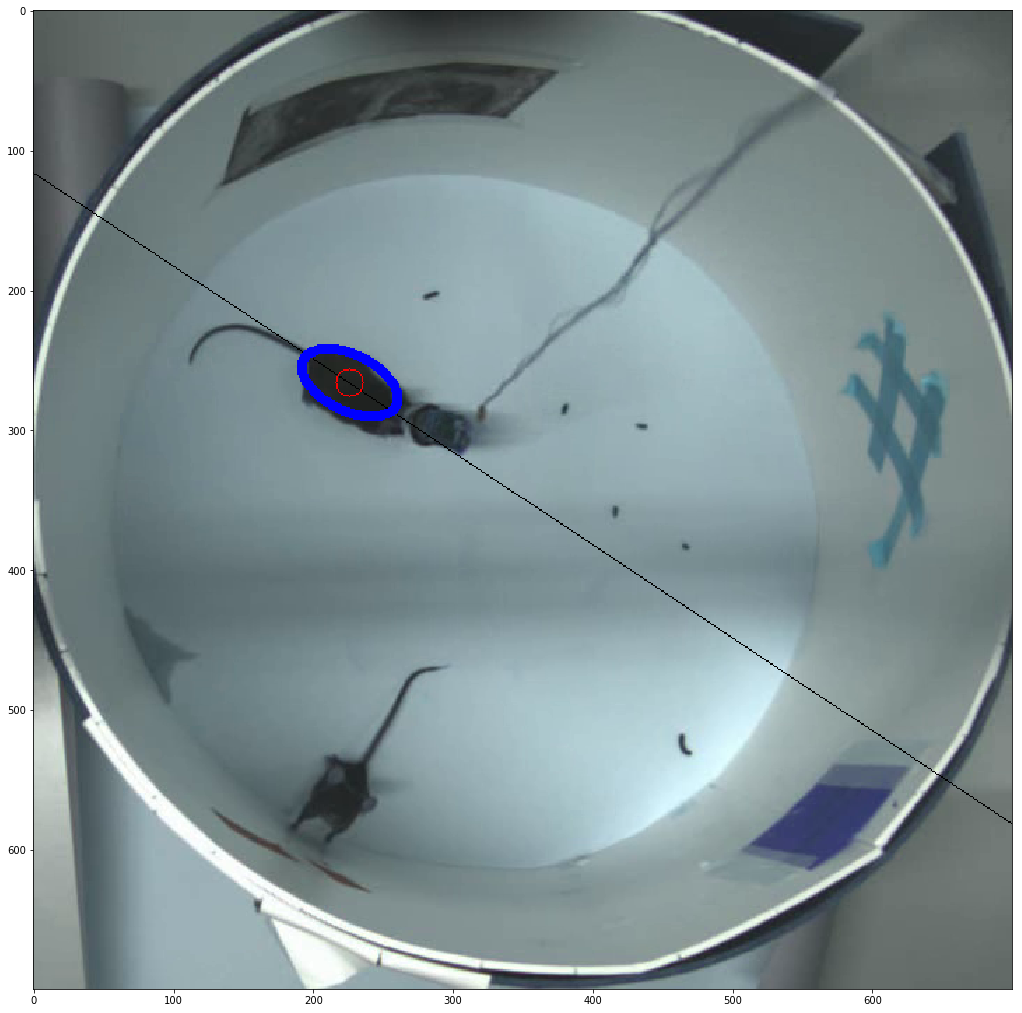

In [261]:
fig, axes = plt.subplots(figsize = (18,18))
axes.imshow(frame)


In [213]:
?cv2.ellipse

Docstring:
ellipse(img, center, axes, angle, startAngle, endAngle, color[, thickness[, lineType[, shift]]]) -> img
.   @brief Draws a simple or thick elliptic arc or fills an ellipse sector.
.   
.   The function cv::ellipse with more parameters draws an ellipse outline, a filled ellipse, an elliptic
.   arc, or a filled ellipse sector. The drawing code uses general parametric form.
.   A piecewise-linear curve is used to approximate the elliptic arc
.   boundary. If you need more control of the ellipse rendering, you can retrieve the curve using
.   #ellipse2Poly and then render it with #polylines or fill it with #fillPoly. If you use the first
.   variant of the function and want to draw the whole ellipse, not an arc, pass `startAngle=0` and
.   `endAngle=360`. If `startAngle` is greater than `endAngle`, they are swapped. The figure below explains
.   the meaning of the parameters to draw the blue arc.
.   
.   ![Parameters of Elliptic Arc](pics/ellipse.svg)
.   
.   @param img Image